# 1. Data Colletion
Extract zip file downloaded using Kaggle API

In [1]:
import zipfile

with zipfile.ZipFile("loan-prediction-problem-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("loan_data")


Importing the Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Importing the training Dataset


In [10]:
data = pd.read_csv("loan_data/train_u6lujuX_CVtuZ9i.csv")
data.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [11]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


# 2. Procressing the Dataset

In [13]:
data.isnull().sum() 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Normalizing the data

<Axes: >

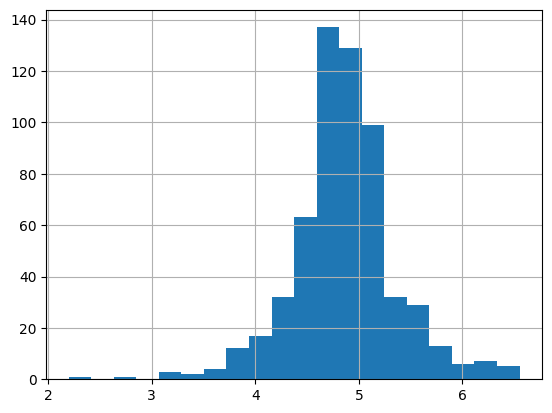

In [14]:
data['loanAmount_log']= np.log(data['LoanAmount']) ## normalising the loan amount and visualizing
data['loanAmount_log'].hist(bins=20)

<Axes: >

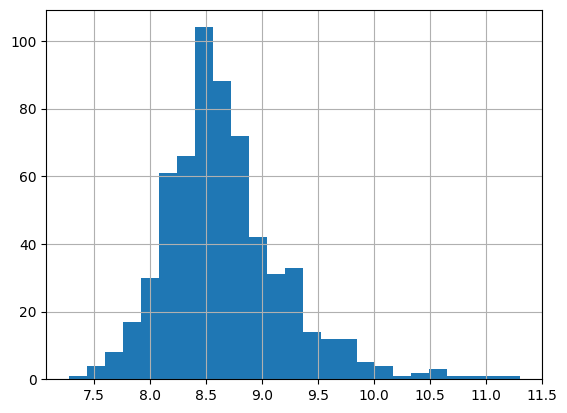

In [15]:
data['totalincome']=data['ApplicantIncome']+data['CoapplicantIncome']  ## making the new attributes
data['totalincome']=np.log(data['totalincome'])  #normalising the new attributes and normalisin g
data['totalincome'].hist(bins=25)

Cleaning and handling the null values

In [16]:
data['Gender'].fillna(data['Gender'].mode()[0], inplace= True)
data['Married'].fillna(data['Married'].mode()[0], inplace= True)
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace= True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace= True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace= True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace= True)

data.LoanAmount = data.LoanAmount.fillna(data.LoanAmount.mean())
data.loanAmount_log = data.loanAmount_log.fillna(data.loanAmount_log.mean())

data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
loanAmount_log       0
totalincome          0
dtype: int64

In [17]:
data.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,loanAmount_log,totalincome
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,4.857444,8.674026
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,4.852030,8.714568
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,4.189655,8.006368
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4.787492,8.505323
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,4.948760,8.699515
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.000000,360.0,1.0,Urban,Y,5.587249,9.170872
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.000000,360.0,1.0,Urban,Y,4.553877,8.255569
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.000000,360.0,0.0,Semiurban,N,5.062595,8.619750
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.000000,360.0,1.0,Urban,Y,5.123964,8.618305
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.000000,360.0,1.0,Semiurban,N,5.855072,10.077819


Dividing the dataset into Independent and Dependent variables
- x will denote the independent variables
- y will denote the dependent variables